In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import hipp
import os
import usgsxplore

## Settings

In [3]:
# Paths
PROJECT_DIRECTORY = "data/kh9pc"
RAW_IMAGES = os.path.join(PROJECT_DIRECTORY, "raw_images")
JOINED_IMAGES = os.path.join(PROJECT_DIRECTORY, "joined_images")
PREPROCESSED_IMAGES = os.path.join(PROJECT_DIRECTORY, "preprocessed_images")
CROPPING_BORDERS_FILE = os.path.join(PROJECT_DIRECTORY, "cropping_borders.csv")

QUICKVIEW_FACTOR = 0.05

## Step 1 : Download raw images

To download the raw images we will use [`usgsxplore`](https://github.com/adehecq/usgs_explorer) which is an python interface to the [USGS M2M API](https://m2m.cr.usgs.gov/) to search and download data available from the [Earth Explorer](https://earthexplorer.usgs.gov/) platform.
We will download 2 images and each image is separated in 10 or 12 parts : `_a`, `_b`, `_c`, ...
The total downloading size is 16 Go, so it can take a will. Further more, the stagging links from the [USGS M2M API](https://m2m.cr.usgs.gov/) can take some time.
The downloading include already the extracting of tif files.

In [4]:
username = os.getenv("USGS_USERNAME") or input("Enter your USGS username: ")
token = os.getenv("USGS_TOKEN") or input("Enter your USGS token: ")

entity_ids = ["D3C1214-100097A014", "D3C1214-100097A015"]

api = usgsxplore.API(username, token)
api.download("declassiii", entity_ids, output_dir=RAW_IMAGES)
api.logout()

In [5]:
hipp.tools.optimize_geotifs(RAW_IMAGES)
hipp.tools.generate_quickviews(RAW_IMAGES, QUICKVIEW_FACTOR, max_workers=8)

Generating quickviews: 100%|██████████| 22/22 [00:13<00:00,  1.68image/s]


## Step 2 : Joining Images

The first step of the preprocessing pipeline is to **join multiple image tiles** into a single, continuous image. This process is necessary because **KH9 PC images are typically split into 10-12 separate parts**, each approximately **1 GB in size**, due to their large original resolution.

However, **joining these image parts is not straightforward**, primarily because there is a **slight overlap between adjacent tiles**. 

To accurately reconstruct the full image, we need to perform the following steps:

1. **Detect keypoints (interest points)** along the **right border** of the first image part.
2. Detect corresponding keypoints along the **left border** of the next image part.
3. **Match these keypoints** using a feature-matching algorithm to find candidate correspondences.
4. Use **RANSAC (Random Sample Consensus)** to filter out mismatched or erroneous correspondences (i.e., outliers).
5. Estimate a **relative geometric transformation** (typically a translation or affine transform) to correctly align the second image with the first.
6. Apply this transformation and **merge the two parts** into a larger composite image.

This process is repeated sequentially for all image parts, progressively building up the full image mosaic.

To perform that 2 functions exists:
- `join_images_asp` : which will use [`image_mosaic`](https://stereopipeline.readthedocs.io/en/latest/tools/image_mosaic.html) program from Ames Stereo Pipeline. This function is much more safer but it requiered to install ASP and the command need to be visible in your path.
- `join_images` : is a pure Python implementation that replicates the same processing steps, it's faster an generate some qc plots. (8 min vs 40 min for asp)


In [6]:
#hipp.kh9pc.join_images_asp(RAW_IMAGES, JOINED_IMAGES)

hipp.kh9pc.join_images(RAW_IMAGES, JOINED_IMAGES, qc_output=os.path.join(PROJECT_DIRECTORY, "qc"))

hipp.tools.generate_quickviews(JOINED_IMAGES, QUICKVIEW_FACTOR, max_workers=8)

Matching 'data/kh9pc/raw_images/D3C1214-100097A014_a.tif' with 'data/kh9pc/raw_images/D3C1214-100097A014_b.tif' ...
	- Number of matching points before versus after ransac : 15462/20267
Matching 'data/kh9pc/raw_images/D3C1214-100097A014_b.tif' with 'data/kh9pc/raw_images/D3C1214-100097A014_c.tif' ...
	- Number of matching points before versus after ransac : 7988/15522
Matching 'data/kh9pc/raw_images/D3C1214-100097A014_c.tif' with 'data/kh9pc/raw_images/D3C1214-100097A014_d.tif' ...
	- Number of matching points before versus after ransac : 8944/18127
Matching 'data/kh9pc/raw_images/D3C1214-100097A014_d.tif' with 'data/kh9pc/raw_images/D3C1214-100097A014_e.tif' ...
	- Number of matching points before versus after ransac : 7775/16861
Matching 'data/kh9pc/raw_images/D3C1214-100097A014_e.tif' with 'data/kh9pc/raw_images/D3C1214-100097A014_f.tif' ...
	- Number of matching points before versus after ransac : 12451/19207
Matching 'data/kh9pc/raw_images/D3C1214-100097A014_f.tif' with 'data/kh9p

Generating quickviews: 100%|██████████| 2/2 [00:40<00:00, 20.43s/image]


To visualize some qc plot for the mosaicing use the `hipp.kh9pc.qc.process_image_mosaicing_qc` which show for each overlap zone the absolute differences.

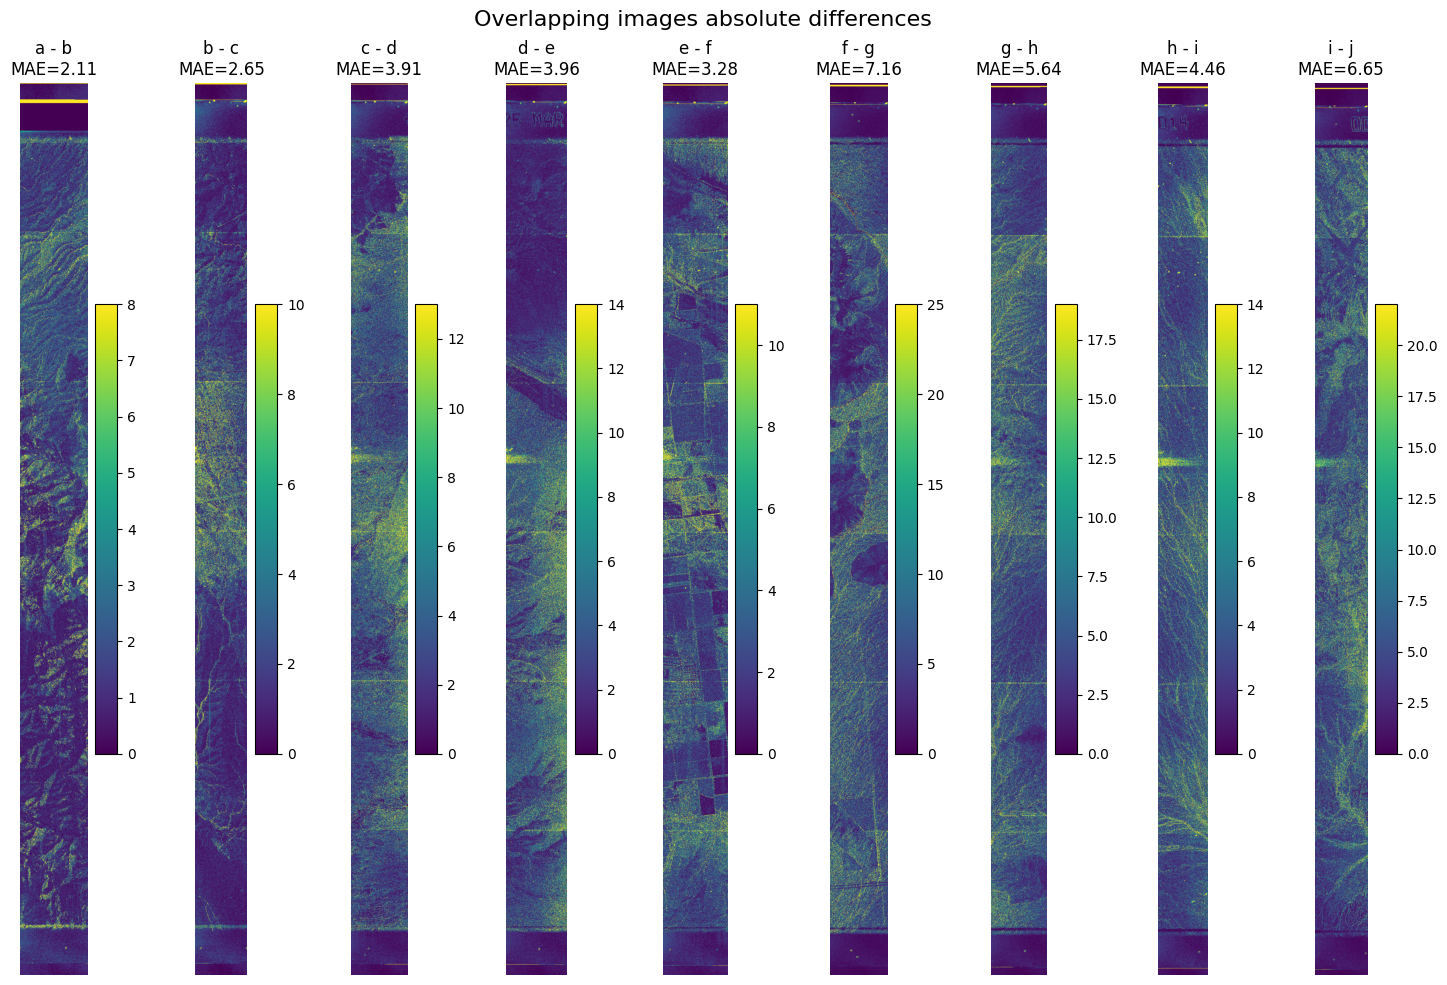

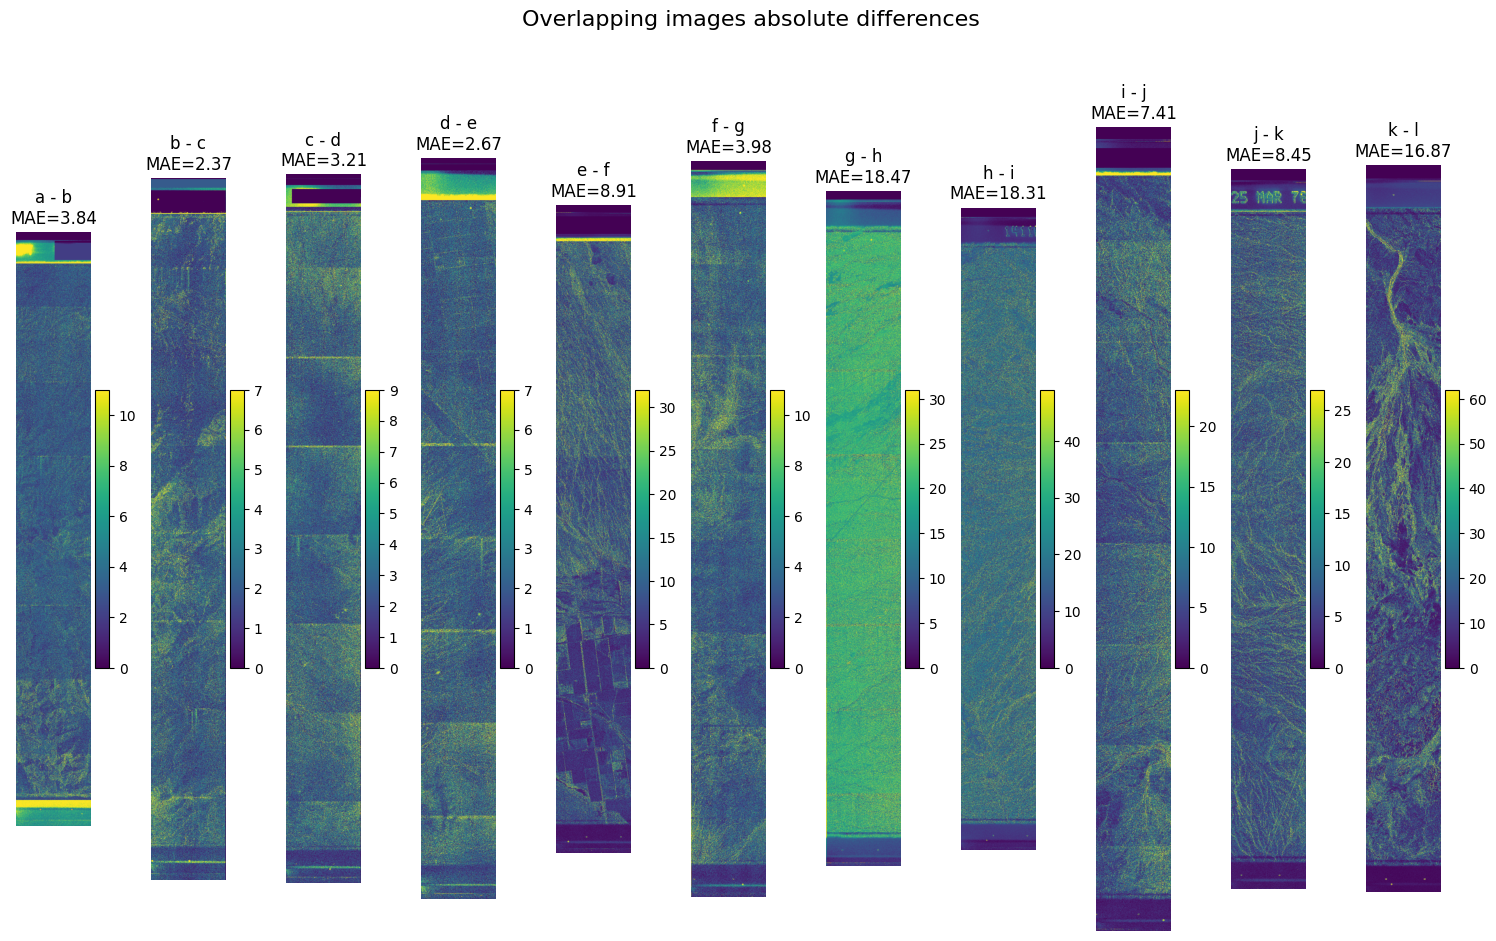

In [7]:
hipp.kh9pc.qc.process_image_mosaicing_qc(os.path.join(PROJECT_DIRECTORY, "qc"))

## Step 3 : Define manualy all cropping points

The function `hipp.kh9pc.select_all_cropping_points` allow you to manually select corners of the region of interest.
- Split each image with 5 x 20 blocks (parameters `grid_shape`)
- open each corners block in an interactive window where you can Ctrl + Click on the corner
- save all results in the csv file (`csv_file`)

**Note** :
- This function dont overwrite existing data in the csv file (if existing)

In [8]:
hipp.kh9pc.select_all_cropping_points(JOINED_IMAGES, CROPPING_BORDERS_FILE)

## Step 4 : Cropping image to remove borders

With the previously generated cropping points, we can use the `hipp.kh9pc.crop_images` to finish the preprocessing.
For each image in the input directory, this function looks up its corresponding cropping points in the CSV file, rotates the image to align the top edge, crops it accordingly, and saves the result in the output directory.

**Note :**

- Images will have different size according to their coresponding croppings points


In [ ]:
#hipp.kh9pc.crop_images(JOINED_IMAGES, CROPPING_BORDERS_FILE, PREPROCESSED_IMAGES)
hipp.tools.generate_quickviews(PREPROCESSED_IMAGES, QUICKVIEW_FACTOR)